# Banking Fraud with various Predictions

## Contents

1. [Background](#Background)
2. [Setup](#Setup)
3. [Data](#Data)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    1. [Investigating the distribution of fraudulent values](#Investigating-the-distribution-of-fraudulent-values)
    2. [Investigating transaction flows](#Investigating-transaction-flows)
    3. [Investigating account names](#Investigating-account-names)
    4. [Investigating transactions](#Investigating-transactions)
    5. [Investigating time](#Investigating-time)
5. [Feature Engineering](#Feature-Engineering)
   1. [Removing columns and specific types](#Removing-columns-and-specific-types)
   2. [Adding the **hourOfDay** feature](#Adding-the-hourOfDay-feature)
   3. [Changing categorical values](#Changing-categorical-values)
   4. [Splitting and standardising](#Splitting-and-standardising)
6. [Problems with data](#Problems-with-data)
7. [Models](#Models)

## Background

There is a lack of public available datasets on financial services and specially in the emerging mobile money transactions domain. Financial datasets are important to many researchers and in particular to us performing research in the domain of fraud detection. Part of the problem is the intrinsically private nature of financial transactions, that leads to no publicly available datasets.

Presented here is a synthetic dataset generated using the simulator called PaySim as an approach to such a problem. PaySim uses aggregated data from the private dataset to generate a synthetic dataset that resembles the normal operation of transactions and injects malicious behaviour to later evaluate the performance of fraud detection methods.

## Setup

Import AWS specific modules and specify S3 data location

In [1]:
# ! pip install seaborn
# import sys
# !{sys.executable} -m pip install --upgrade seaborn
# !{sys.executable} -m pip install --upgrade imbalanced-learn

import boto3
import os
from random import seed, sample
import sagemaker
import sagemaker.amazon.amazon_estimator
from sagemaker import get_execution_role
from sagemaker.serializers import CSVSerializer

Import python ML modules

In [2]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
sns.set_theme()
sns.set_context("paper")

from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, roc_curve, auc, precision_score, recall_score

from sklearn.ensemble import RandomForestClassifier
# from xgboost.sklearn import XGBClassifier

In [3]:
bucket = 'sagemaker-pmelvin'
prefix = 'compile_xgb_v3'
hp_prefix = 'hp_tuning_v3'

csv_data = 'input-data/bb_banking_fraud.csv'
csv_removed_types = 'input-data/removed-specific-types/01a89090-e9b6-4b07-8a49-b0244d6dc035.csv'
data_location = 's3://{}/{}'.format(bucket, csv_data)
#local_file = 'bb_banking_fraud.csv'

role = get_execution_role()
sess = sagemaker.Session()
smclient = boto3.Session().client('sagemaker')

## Data

Import data and perform initial analysis (CSV from S3)

In [4]:
%%time
df = pd.read_csv(data_location)

CPU times: user 9.52 s, sys: 1.96 s, total: 11.5 s
Wall time: 27.6 s


In [5]:
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalancedest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

In [6]:
df.head(n=5)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldbalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [7]:
df.shape

(6362620, 11)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


As we can see from above, the dataset has roughly 6.5 million records, where each record uses 11 attributes (features) to describe the profile of the transactions. The attributes are:
- `step`: maps a unit of time in the real world. In this case 1 step is 1 hour of time
- `type`: CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER
- `amount`: the amount of the transaction in local currency
- `nameOrig`: the customer who started the transaction
- `oldBalanceOrig`: the initial balance before the transaction
- `newBalanceOrig`: the customer's balance after the transaction
- `nameDest`: the recipient ID of the transaction
- `oldBalanceDest`: the initial recipient balance before the transaction
- `newBalanceDest`: the recipient's balance after the transaction
- `isFraud`: this identifies a fraudulent transaction (1) and non fraudulent (0)
- `isFlaggedFraud`: this identifies a flagged fraudulent transaction

# Exploratory Data Analysis

First we check to see if there are any missing values

In [9]:
df.isnull().values.any()

False

## Investigating the distribution of fraudulent values

We know there are five transaction types, lets see how the are distributed

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64



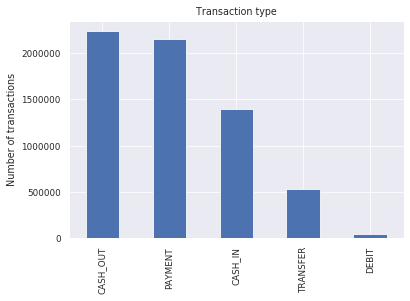

In [10]:
print(df.type.value_counts())
print()

fig = plt.subplots(figsize=(6,4))
ax = df.type.value_counts().plot(kind='bar', title="Transaction type")
ax.set_ylabel("Number of transactions")
plt.show()

We also know that there are two features that look interesting **isFraud** and **isFlaggedFraud** and from the description _isFraud_ indicates actual fraudulent transactions whereas _isFlaggedFraud_ is when the system prevents the transaction due to some condition

Lets see how many transactions are fraudulent

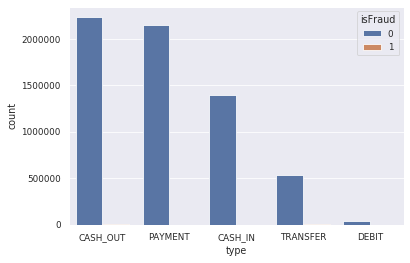

In [11]:
fig = plt.subplots(figsize=(6,4))
sns.countplot(x='type', hue='isFraud', data=df, order = df['type'].value_counts().index)
plt.show()

Its clear there are some fraudulent transactions but it is very difficult to see how many as in comparison to the entire dataset the amount is tiny

Therefore, lets find out how many are actual fraud and in what type

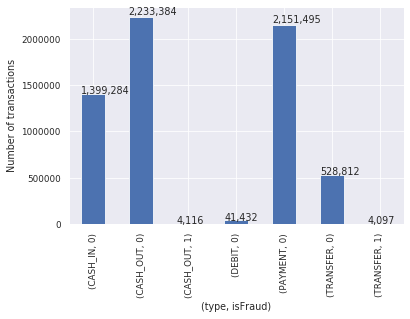

In [12]:
fig = plt.subplots(figsize=(6,4))
ax = df.groupby(['type', 'isFraud']).size().plot(kind='bar')
ax.set_xlabel("(type, isFraud)")
ax.set_ylabel("Number of transactions")

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
plt.show()

From the above it looks like that only **CASH_OUT** and **TRANSFER** have actual fraudulent transactions

Now lets have a look at which transactions are being flagged as fraudulent

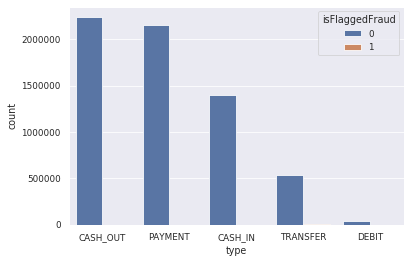

In [13]:
fig = plt.subplots(figsize=(6,4))
sns.countplot(x='type', hue='isFlaggedFraud', data=df, order = df['type'].value_counts().index)
plt.show()

Unlike **isFraud** we cannot even see which are flagged as fraudulent so lets find out which type

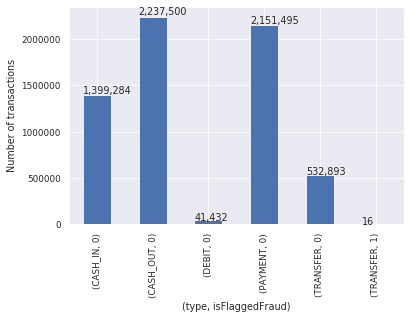

In [14]:
fig = plt.subplots(figsize=(6,4))
ax = df.groupby(['type', 'isFlaggedFraud']).size().plot(kind='bar')
ax.set_xlabel("(type, isFlaggedFraud)")
ax.set_ylabel("Number of transactions")

for p in ax.patches:
    ax.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))
plt.show()

From the above plot it looks like that only **TRANSFER** has any flagged transactions and the amount is only 16 records out of 6.5 million!

Due to the insignificant percentage we can also remove th **isFlaggedFraud** feature as well

So we now know that we can focus on **CASH_OUT** and **TRANSFER** and remove the other types, now let's have a look at the source and direction of the transcactions

## Investigating transaction flows

Just as a recap let's look at some of our data

In [15]:
df.head(n=5)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldbalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


We will focus on the **nameOrig** and **nameDest** and see if we can see a pattern

The format for the value has either a **C** or **M** before some digits. However, the letters are not defined, and it would be reasonable to assume that **C** stands for **Customer** and **M** stands for **Merchant**, let's have a look at the relationships between transaction flows between **C** and **M**

We will create a new feature called _direction_ which will correlate to the following:
1. CC - Customer to customer
2. CM - Customer to merchant
3. MC - Merchant to customer
4. MM - Merchant to merchant

In [16]:
%%time
df_direction = df.copy()
df_direction['direction'] = np.nan

df_direction.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('C'),"direction"] = "CC" 
df_direction.loc[df.nameOrig.str.contains('C') & df.nameDest.str.contains('M'),"direction"] = "CM"
df_direction.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('C'),"direction"] = "MC"
df_direction.loc[df.nameOrig.str.contains('M') & df.nameDest.str.contains('M'),"direction"] = "MM"

CPU times: user 23.3 s, sys: 1.31 s, total: 24.6 s
Wall time: 24.6 s


Let's split up the fraudulent and non-fraudlent transactions so we can refer to these later

In [17]:
fraud = df_direction[df_direction["isFraud"] == 1]
valid = df_direction[df_direction["isFraud"] == 0]

In [18]:
print("Fraud transactions by direction:\n",fraud.direction.value_counts())
print()
print("Valid transactions by direction:\n",valid.direction.value_counts())

Fraud transactions by direction:
 CC    8213
Name: direction, dtype: int64

Valid transactions by direction:
 CC    4202912
CM    2151495
Name: direction, dtype: int64


From the above it looks like the only fraudulent transactions occur between customer accounts (CC) so like the type above we can remove the extraneous information when we do feature engineering

Using the new table we can confirm that **CASH_OUT** and **TRANSFER** are the only types with fraudulent activity

## Investigating account names

We now need to figure out if the originator and the destination are the same relating to removing the money using the **CASH_OUT**

First we start by confirming that only the **CASH_OUT** and **TRANSFER** have the fraudulent activities

In [19]:
cash_in=df.loc[(df.isFraud==1) & (df.type=='CASH_IN')]
cash_out=df.loc[(df.isFraud==1) & (df.type=='CASH_OUT')]
debit=df.loc[(df.isFraud==1) & (df.type=='DEBIT')]
payment=df.loc[(df.isFraud==1) & (df.type=='PAYMENT')]
transfer=df.loc[(df.isFraud==1) & (df.type=='TRANSFER')]

print('Fraudulent transacions in CASH_IN',len(cash_in))
print('Fraudulent transacions in CASH_OUT',len(cash_out))
print('Fraudulent transacions in DEBIT',len(debit))
print('Fraudulent transacions in PAYMENT',len(payment))
print('Fraudulent transacionsin TRANSFER',len(transfer))

Fraudulent transacions in CASH_IN 0
Fraudulent transacions in CASH_OUT 4116
Fraudulent transacions in DEBIT 0
Fraudulent transacions in PAYMENT 0
Fraudulent transacionsin TRANSFER 4097


Which they are, so that is good :) (well not really!)

Now we need to test whether the account to _cashout_ is actually used to remove the money

In [20]:
fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]

fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any()

False

This returns false, so we now know that the account used to remove the fund was not the same as the one that received the funds

Therefore, we can remove the **nameOrig** and **nameDest** as well

## Investigating transactions

What are the amounts of fraudulent vs legitimate transactions

In [21]:
pd.set_option('float_format', '{:,.2f}'.format)
print("Description of amounts moved in fraudulent transactions: \n",pd.DataFrame.describe(fraud.amount),"\n")
print("Description of amounts moved moved in legitimate transactions: \n", pd.DataFrame.describe(valid.amount),"\n")

Description of amounts moved in fraudulent transactions: 
 count        8,213.00
mean     1,467,967.30
std      2,404,252.95
min              0.00
25%        127,091.33
50%        441,423.44
75%      1,517,771.48
max     10,000,000.00
Name: amount, dtype: float64 

Description of amounts moved moved in legitimate transactions: 
 count    6,354,407.00
mean       178,197.04
std        596,236.98
min              0.01
25%         13,368.40
50%         74,684.72
75%        208,364.76
max     92,445,516.64
Name: amount, dtype: float64 



From the above we can clearly see that the maximum amount for a fraudulent transaction is 10 million, with the average of 1.5 million, however there is no real limit for legimate transactions (maximum of 100 million) but the average is much lower, around 200 thousand

Now lets have a look at the balances before and after the transaction

In [22]:
wrong_originating_bal = sum(df["oldBalanceOrig"] - df["amount"] != df["newBalanceOrig"])
wrong_destination_bal = sum(df["newBalanceDest"] + df["amount"] != df["newBalanceDest"])

print("% of transactions with balance errors in the originating account: ", 100*round(wrong_originating_bal/len(df),2))
print("% of transactions with balance errors in the destination account: ", 100*round(wrong_destination_bal/len(df),2))

% of transactions with balance errors in the originating account:  85.0
% of transactions with balance errors in the destination account:  100.0


So it looks like almost all of the balance/transactions have errors, so let's have a closer look

In [23]:
amount_given = sum(df["amount"] > df["oldBalanceOrig"])
amount_given = "{:,}".format(amount_given)
print("The number of occurances where the amount given is greater than the amount that is in the originator's account: ", amount_given)

amount_received = sum(df["amount"] > df["newBalanceDest"])
amount_received = "{:,}".format(amount_received)
print("The number of occurances where the amount received is greater than the amount that is in the receiver's account: ", amount_received)

The number of occurances where the amount given is greater than the amount that is in the originator's account:  4,079,080
The number of occurances where the amount received is greater than the amount that is in the receiver's account:  2,661,141


So from the above we can confirm that there are some fundamental erros in the datset as normally it would be impossible to give/receive more than than is availble in your account, therefore we cannot ignore this values but simply be aware of them (and the errors within)

## Investigating time

For the final look at the dataset, we will look at the time or **step**

We know that the **step** relates to 1 hour over a period of thrity days and we need to have a look if there is any correlation to fraudulent transactions over days or hours

Let's start with having a look over the entire month

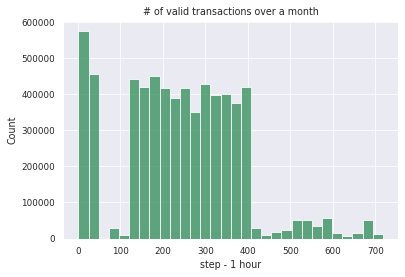

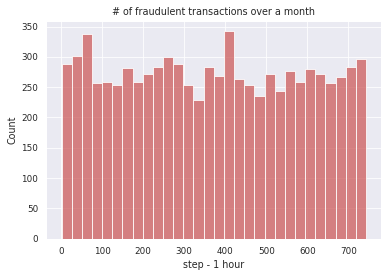

In [24]:
sns.histplot(valid, x='step', bins=30, color='seagreen')
plt.xlabel("step - 1 hour")
plt.title("# of valid transactions over a month")
plt.show()

sns.histplot(fraud, x='step', bins=30, color='indianred')
plt.xlabel("step - 1 hour")
plt.title("# of fraudulent transactions over a month")
plt.show()

As we can see from the above:
- for valid transactions, the majority occurs between steps 0 - 60 and 125 - 400
- for fraudulent transactions, there is no real pattern, they occur at all times

Now let's have a look over a week

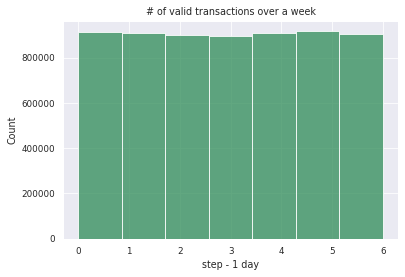

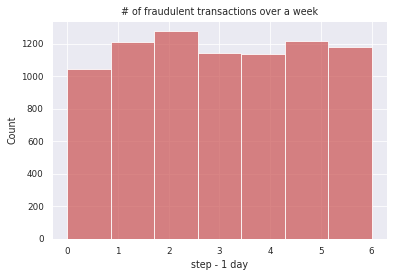

In [25]:
days = 7

fraud_days = fraud.step % days
valid_days = valid.step % days

sns.histplot(valid_days, bins=days, color='seagreen')
plt.xlabel("step - 1 day")
plt.title("# of valid transactions over a week")
plt.show()

sns.histplot(fraud_days, bins=days, color='indianred')
plt.xlabel("step - 1 day")
plt.title("# of fraudulent transactions over a week")
plt.show()

From the above there is no indication that fraudulent transactions happen on a particular day, they occur every day

Now let's have a look at hours

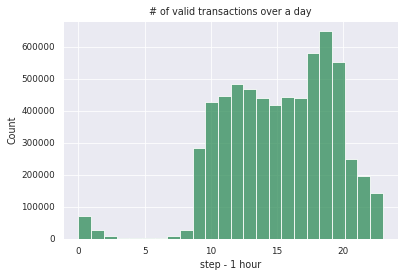

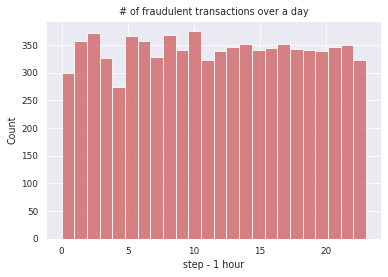

In [26]:
hours = 24

fraud_hours = fraud.step % hours
valid_hours = valid.step % hours

sns.histplot(valid_hours, bins=hours, color='seagreen')
plt.xlabel("step - 1 hour")
plt.title("# of valid transactions over a day")
plt.show()

sns.histplot(fraud_hours, bins=hours, color='indianred')
plt.xlabel("step - 1 hour")
plt.title("# of fraudulent transactions over a day")
plt.show()

So, what can we infer from the above?

It looks like that fraudulent transactions occur all hours of the day but valid transactions do not seem to occur in the steps between 0 - 9

Therefore, it is a good idea to create a new feature based on hours

In [27]:
df['hourOfDay'] = np.nan
df.hourOfDay = df_direction.step % 24

In [28]:
df.head(n=5)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldbalanceDest,newBalanceDest,isFraud,isFlaggedFraud,hourOfDay
0,1,PAYMENT,"9,839.64",C1231006815,"170,136.00","160,296.36",M1979787155,0.00,0.00,0,0,1
1,1,PAYMENT,"1,864.28",C1666544295,"21,249.00","19,384.72",M2044282225,0.00,0.00,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1,0,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,"21,182.00",0.00,1,0,1
4,1,PAYMENT,"11,668.14",C2048537720,"41,554.00","29,885.86",M1230701703,0.00,0.00,0,0,1


# Feature Engineering

First, let's have a recap of which features we can remove from our investigations

From the **type** feature we are only interested in **CASH_OUT** and **TRANSFER**

We also don't need to include **nameOrig** and **nameDest**

**isFlaggedFraud** is neglible so we can also remove that (remember there were only sixteen values)

## Removing columns and specific types

Although we can remove these features using pandas, it is worth using other tools (Glue and Athena) to reduce th dataset and then reload and continue with the feature engineering process

In [29]:
from IPython.display import Image

![title](img/glue_transform.png)

and I need to add some code to combine the standard frames into one **dynamic_Frame=applymapping1.coalesce(1)**

once I have run another crawler, I use Athena to remove the specific types to only leave **CASH_OUT** and **TRANSFER**

SELECT *\
FROM removed_columns\
WHERE type = 'CASH_OUT' or type = 'TRANSFER';

the new file is then saved to S3 which i can then use directly (as it is a CSV) or convert it parquet using Glue (as before)

So some information on the origanl file and the feature engineered (well basic cleaning so far)

Original CSV file size    : 470.7MB\
Origanal Parquet file size: 274.8MB

Columns removed CSV file size    : 319.2MB\
Columns removed Parquet file size: 158.1MB

Feature **type** cleaned CSV file size    : 187.1MB\
Feature **type** cleaned Parquet file size: 80.1MB

In [30]:
csv_original      = 's3://sagemaker-pmelvin/input-data/bb_banking_fraud.csv'
csv_removed_cols  = 's3://sagemaker-pmelvin/input-data/removed_columns/run-1606989332572-part-r-00000'
csv_removed_types = 's3://sagemaker-pmelvin/input-data/removed-specific-types/01a89090-e9b6-4b07-8a49-b0244d6dc035.csv'

par_original      = 's3://sagemaker-pmelvin/input-parquet-single/part-00000-28137ef0-c04d-436a-8b20-ae663dbe740b-c000.snappy.parquet'
par_removed_cols  = 's3://sagemaker-pmelvin/input-parquet-single/removed-columns/part-00000-c88815d4-0920-4ab0-bb77-b160ab9dbc09-c000.snappy.parquet'
par_removed_types = 's3://sagemaker-pmelvin/input-parquet-single/removed-specific-types/part-00000-c2ad1434-15f7-4fb0-afb2-54757f53e21b-c000.snappy.parquet'

In [31]:
# local
# csv_original      = 'bb_banking_fraud.csv'
# csv_removed_cols  = 'run-1606989332572-part-r-00000'
# csv_removed_types = '01a89090-e9b6-4b07-8a49-b0244d6dc035.csv'

# par_original      = 'part-00000-28137ef0-c04d-436a-8b20-ae663dbe740b-c000.snappy.parquet'
# par_removed_cols  = 'part-00000-c88815d4-0920-4ab0-bb77-b160ab9dbc09-c000.snappy.parquet'
# par_removed_types = 'part-00000-c2ad1434-15f7-4fb0-afb2-54757f53e21b-c000.snappy.parquet'

Let's load and quickly double-check

In [32]:
# %%time
# df_csv_original = pd.read_csv(csv_original)

In [33]:
# %%time
# df_csv_removed_cols = pd.read_csv(csv_removed_cols)

In [34]:
%%time
df_csv_removed_types = pd.read_csv(csv_removed_types)

CPU times: user 2 s, sys: 546 ms, total: 2.55 s
Wall time: 10.2 s


In [35]:
# df_csv_original.shape

In [36]:
# df_csv_original.head(n=5)

In [37]:
# df_csv_removed_cols.shape

In [38]:
# df_csv_removed_cols.head(n=5)

In [39]:
df_csv_removed_types.shape

(2770409, 8)

In [40]:
df_csv_removed_types.head(n=5)

,step,type,amount,oldbalanceorg,newbalanceorig,oldbalancedest,newbalancedest,isfraud
0,282,CASH_OUT,"32,211.98","50,286.00","18,074.02","1,822,919.25","1,855,131.23",0
1,282,CASH_OUT,"160,345.98","10,547.53",0.00,"1,315,244.93","1,444,936.49",0
2,282,CASH_OUT,"131,693.09",882.00,0.00,0.00,"131,693.09",0
3,282,CASH_OUT,"275,852.42","31,079.00",0.00,"314,930.74","590,783.16",0
4,282,CASH_OUT,"37,745.48","5,097.00",0.00,0.00,"37,745.48",0


So in summary, so far, for the CSV files the load time comes down by a factor of about 2 which is great!

Let's fix those column names again

In [41]:
df_csv_removed_types = df_csv_removed_types.rename(columns={'oldbalanceorg':'oldBalanceOrig', 'newbalanceorig':'newBalanceOrig', 'oldbalancedest':'oldBalanceDest', 'newbalancedest':'newBalanceDest', 'isfraud':'isFraud'})

In [42]:
df = df_csv_removed_types
df.head(n=5)

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud
0,282,CASH_OUT,"32,211.98","50,286.00","18,074.02","1,822,919.25","1,855,131.23",0
1,282,CASH_OUT,"160,345.98","10,547.53",0.00,"1,315,244.93","1,444,936.49",0
2,282,CASH_OUT,"131,693.09",882.00,0.00,0.00,"131,693.09",0
3,282,CASH_OUT,"275,852.42","31,079.00",0.00,"314,930.74","590,783.16",0
4,282,CASH_OUT,"37,745.48","5,097.00",0.00,0.00,"37,745.48",0


In [43]:
df.shape

(2770409, 8)

## Adding the **hourOfDay** feature

In [44]:
df_copy = df.copy()

df['hourOfDay'] = np.nan
df.hourOfDay = df_copy.step % 24

In [45]:
df.head(n=5)

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,hourOfDay
0,282,CASH_OUT,"32,211.98","50,286.00","18,074.02","1,822,919.25","1,855,131.23",0,18
1,282,CASH_OUT,"160,345.98","10,547.53",0.00,"1,315,244.93","1,444,936.49",0,18
2,282,CASH_OUT,"131,693.09",882.00,0.00,0.00,"131,693.09",0,18
3,282,CASH_OUT,"275,852.42","31,079.00",0.00,"314,930.74","590,783.16",0,18
4,282,CASH_OUT,"37,745.48","5,097.00",0.00,0.00,"37,745.48",0,18


Or we can also perform the same action in Athena

SELECT *,  MOD(step, 24) timeofday\
from removed_columns 

which returns a CSV file with a new column **timeofday** which is _step % 24_

In [46]:
# csv_modulus       = 'a7aa763d-235b-45d1-bed6-3364ead885bc.csv'

 ## Changing categorical values

Most of the machine learning algorithms can not handle categorical variables unless we convert them to numerical values. Many algorithm’s performances vary based on how Categorical variables are encoded.

Categorical variables can be divided into two categories: Nominal (No particular order) and Ordinal (some ordered).

Since there is no ordering we will use **One-Hot encoding**.\
In this method, we map each category to a vector that contains 1 and 0 denoting the presence or absence of the feature. The number of vectors depends on the number of categories for features. This method produces a lot of columns that slows down the learning significantly if the number of the category is very high for the feature.

pandas has the **get_dummies** function

In [47]:
df_with_dummies = pd.get_dummies(df, prefix=['type'])

In [48]:
df_with_dummies.head(n=5)

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,hourOfDay,type_CASH_OUT,type_TRANSFER
0,282,"32,211.98","50,286.00","18,074.02","1,822,919.25","1,855,131.23",0,18,1,0
1,282,"160,345.98","10,547.53",0.00,"1,315,244.93","1,444,936.49",0,18,1,0
2,282,"131,693.09",882.00,0.00,0.00,"131,693.09",0,18,1,0
3,282,"275,852.42","31,079.00",0.00,"314,930.74","590,783.16",0,18,1,0
4,282,"37,745.48","5,097.00",0.00,0.00,"37,745.48",0,18,1,0


In [49]:
df_u = df_with_dummies.copy()


## Splitting and standardising

To train any machine learning model irrespective what type of dataset is being used you have to **split** the dataset into training data and testing data.

scikit has **train_test_split** function

In [50]:
# to allow reproducible splitting we define a RandomState and seed
randomstate = 25
seed(10)

We will move the **isFraud** column to the front as some algorithmns require the first feature to be the one we are investigating

In [51]:
first_col = df_u.pop('isFraud')

In [52]:
df_u.insert(0, 'isFraud', first_col)

In [53]:
df_u.head(n=5)

,isFraud,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,hourOfDay,type_CASH_OUT,type_TRANSFER
0,0,282,"32,211.98","50,286.00","18,074.02","1,822,919.25","1,855,131.23",18,1,0
1,0,282,"160,345.98","10,547.53",0.00,"1,315,244.93","1,444,936.49",18,1,0
2,0,282,"131,693.09",882.00,0.00,0.00,"131,693.09",18,1,0
3,0,282,"275,852.42","31,079.00",0.00,"314,930.74","590,783.16",18,1,0
4,0,282,"37,745.48","5,097.00",0.00,0.00,"37,745.48",18,1,0


In [54]:
X = df_u.drop('isFraud', 1)
y = df_u.isFraud

In [55]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1 - train_ratio)

# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 

# print(X_train, X_val, X_test)

In [56]:
# X_train, X_val, X_test = np.split(df_with_dummies.sample(frac=1), [int(0.7 * len(df)), int(0.9 * len(df))])

In [57]:
print(f"The X_train shape is {X_train.shape} and the y_train shape is {y_train.shape}")
print(f"The X_test shape is {X_test.shape} and the y_test shape is {y_test.shape}")

The X_train shape is (2077806, 9) and the y_train shape is (2077806,)
The X_test shape is (692603, 9) and the y_test shape is (692603,)


The above splits the data but is it the best option?

Possibly not, as the split will always have the same data and this can lead to what is described as the **bias-variance-tradeoff**

To combat this we can use **cross-validation**, which is a method of model validation which splits the data in creative ways in order to obtain the better estimates of “real world” model performance, and minimise validation error.

**K-fold** validation is a popular method of cross validation which shuffles the data and splits it into k number of folds (groups). In general K-fold validation is performed by taking one group as the test data set, and the other k-1 groups as the training data, fitting and evaluating a model, and recording the chosen score. This process is then repeated with each fold (group) as the test data and all the scores averaged to obtain a more comprehensive model validation score.

TODO

What do we mean by **standardisation**?

**Standardise** generally means changing the values so that the distribution standard deviation from the mean equals one. It outputs something very close to a normal distribution. Scaling is often implied.

**Scaling** generally means to change the range of the values. The shape of the distribution doesn’t change. Think about how a scale model of a building has the same proportions as the original, just smaller. That’s why we say it is drawn to scale. The range is often set at 0 to 1.

Many machine learning algorithms perform better or converge faster when features are on a relatively similar scale and/or close to normally distributed. **Scaling** and **standardising** can help features arrive in more digestible form for these algorithms.

In [58]:
# scaler = StandardScaler()
scaler = MinMaxScaler()
scaler.fit(X_train)

MinMaxScaler()

In [59]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

So we are done! right? no

I skipped ahead a bit and did some testing with xgboost but the model did not perform, why?

Well it turns out that although we have cleaned the data, we still have the issue that the fraudulent transactions is a tiny percentage, let's explore that a bit more

# Problems with data?

Let's load the data again and rename the columns once again

In [4]:
%%time
df = pd.read_csv(data_location)

CPU times: user 9.41 s, sys: 2.24 s, total: 11.7 s
Wall time: 23.3 s


In [5]:
df.head(n=5)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [6]:
df_u = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', 'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest', 'isfraud':'isFraud'})

In [7]:
df_u.head(n=5)

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


We know there are about 8000 fraudulent records, let's just check that

In [8]:
df_u.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

6 million rows are too many to perform testing, so let's take a much smaller sample to use

In [9]:
df_copy = df_u.copy()

df_u['hourOfDay'] = np.nan
df_u.hourOfDay = df_copy.step % 24

In [10]:
first_col = df_u.pop('isFraud')

In [11]:
df_u.insert(0, 'isFraud', first_col)

In [12]:
sample = df_u.sample(n=10000, random_state=42)

In [13]:
sample.head(n=5)

,isFraud,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFlaggedFraud,hourOfDay
3737323,0,278,CASH_IN,330218.42,C632336343,20866.00,351084.42,C834976624,452419.57,122201.15,0,14
264914,0,15,PAYMENT,11647.08,C1264712553,30370.00,18722.92,M215391829,0.00,0.00,0,15
85647,0,10,CASH_IN,152264.21,C1746846248,106589.00,258853.21,C1607284477,201303.01,49038.80,0,10
5899326,0,403,TRANSFER,1551760.63,C333676753,0.00,0.00,C1564353608,3198359.45,4750120.08,0,19
2544263,0,206,CASH_IN,78172.30,C813403091,2921331.58,2999503.88,C1091768874,415821.90,337649.60,0,14


In [14]:
sample.isFraud.value_counts()

0    9981
1      19
Name: isFraud, dtype: int64

From our previous analysis we know that some features can be dropped (**step** and **nameOrig** and **nameDest** and **isFlaggedFraud**)

We will re-add the **hourOfDay** and then move **isFraud** to the front

We will create a couple of functions:

1. **get_feature** to return a cleaned dataset
2. **reduce_features** to take advanteg of PCA to compare to the above
3. **produce_plot** to plot the data

In [15]:
def get_features(df):
    
    selected_cols = ['type', 'amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest', 'isFraud', 'hourOfDay']
    
    df = df[selected_cols].copy()
    dummies = pd.get_dummies(df.type)
    df = pd.concat([df, dummies], axis=1).drop("type", axis=1)
    
    return df

In [16]:
def reduce_features(pca_df):
    
    pca_df = pca_df.copy()
    target = pca_df.pop("isFraud")
    scaler = StandardScaler()
    pca_df = scaler.fit_transform(pca_df)
    pca = PCA(n_components=2)
    components = pca.fit_transform(pca_df)

    comp_df = pd.DataFrame(components, columns=["X", "y"])
    target = target.reset_index(drop=True)
    plot_df = pd.concat([comp_df, target], axis=1)
    
    return plot_df

In [17]:
def produce_plot(plot_df, maj_alpha=0.5, min_alpha=1, save=None):
    
    fig, ax = plt.subplots(figsize=(8, 6))
    ax = sns.scatterplot(x="X", y="y", alpha=maj_alpha, data=plot_df[plot_df.isFraud == 0], label="Legitimate")
    sns.scatterplot(x="X", y="y", alpha=min_alpha, data=plot_df[plot_df.isFraud == 1], ax=ax, label="Fraud")
    plt.title("Legitimate vs Fraudulent Purchases")
    plt.tight_layout()
    if save != None:
        plt.savefig(save)
    plt.show()
    
    pass

So let's use tha above on the sample data to see what it looks like before oversampling the data (we will define oversampling in a moment)

In [16]:
processed_data = get_features(sample)
plot_df        = reduce_features(processed_data)

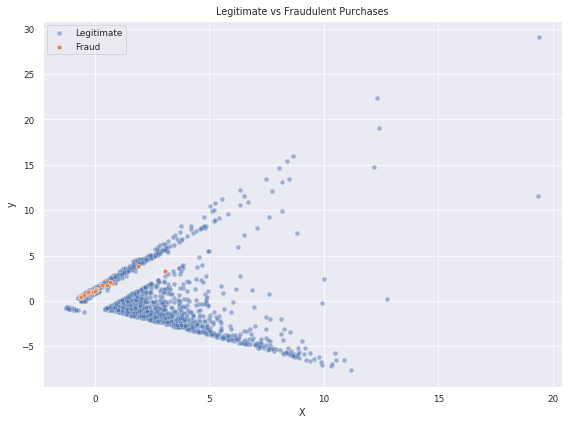

In [17]:
produce_plot(plot_df)

A very pretty scatterplot but unfortunately confirms what we thought, not many (or enough) fraudulent transactions, let's fix that but first we should define what oversampling is

There are two that we should investigate and then choose the best one, the first is **Random Undersampling** and **SMOTE**

**Random Oversampling** includes selecting random examples from the minority class with replacement and supplementing the training data with multiple copies of this instance, hence it is possible that a single instance may be selected multiple times

**Random Undersampling** is the opposite to Random Oversampling. This method seeks to randomly select and remove samples from the majority class, consequently reducing the number of examples in the majority class in the transformed data

SMOTE or **Synthetic Minority Oversampling Technique** is an oversampling technique but SMOTE working differently

In a classic oversampling technique, the minority data is duplicated from the minority data population. While it increases the number of data points, it does not give any new information or variation to the machine learning model

SMOTE works by utilising a **k-nearest neighbour** algorithm to create synthetic data. SMOTE first starts by choosing random data from the minority class, then k-nearest neighbours from the data are set. Synthetic data would then made between the random data and the randomly selected k-nearest neighbour

So let's start with **Random Oversampling** but first we will define the method that be be used for either technique

In [18]:
def resample(df, method):

    processed_df = get_features(df)
    target = processed_df.pop('isFraud')

    processed_x, processed_y = method.fit_resample(processed_df, target)

    cols = list(processed_df.columns) + ["isFraud"]

    pdf_x = pd.DataFrame(processed_x, columns=processed_df.columns)
    pdf_y = pd.DataFrame(processed_y, columns=['isFraud'])
    resampled_df = pd.concat([pdf_x, pdf_y], axis=1)
    
    return resampled_df

We need to import the module and then define some attibutes

In [78]:
from imblearn.over_sampling import RandomOverSampler

In [79]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=42)

In [80]:
ros_resampled = resample(sample, ros)
print(ros_resampled.shape)
print()
print(ros_resampled.isFraud.value_counts())

(19962, 12)

1    9981
0    9981
Name: isFraud, dtype: int64


In [81]:
ros_resampled.head()

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,hourOfDay,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,"330,218.42","20,866.00","351,084.42","452,419.57","122,201.15",14,1,0,0,0,0,0
1,"11,647.08","30,370.00","18,722.92",0.00,0.00,15,0,0,0,1,0,0
2,"152,264.21","106,589.00","258,853.21","201,303.01","49,038.80",10,1,0,0,0,0,0
3,"1,551,760.63",0.00,0.00,"3,198,359.45","4,750,120.08",19,0,0,0,0,1,0
4,"78,172.30","2,921,331.58","2,999,503.88","415,821.90","337,649.60",14,1,0,0,0,0,0


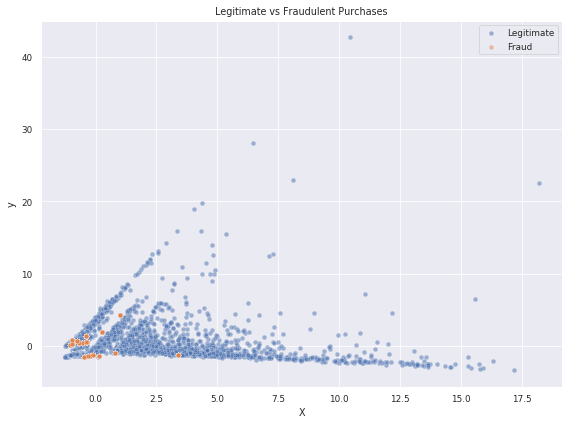

In [82]:
produce_plot(reduce_features(ros_resampled), min_alpha=0.5)

In [83]:
from imblearn.under_sampling import RandomUnderSampler

In [84]:
rus = RandomUnderSampler(sampling_strategy={0: 9589}, random_state=42)

In [85]:
rus_resampled = resample(df_u, rus)
print(rus_resampled.shape)
print()
print(rus_resampled.isFraud.value_counts())

(17802, 12)

0    9589
1    8213
Name: isFraud, dtype: int64


In [86]:
rus_resampled.head()

,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,hourOfDay,CASH_IN,CASH_OUT,DEBIT,PAYMENT,TRANSFER,isFraud
0,"183,806.32","19,391.00",0.00,"382,572.19","566,378.51",18,0,1,0,0,0,0
1,521.37,0.00,0.00,0.00,0.00,17,0,0,0,1,0,0
2,"3,478.18","19,853.00","16,374.82",0.00,0.00,11,0,0,0,1,0,0
3,"1,716.05","5,769.17","4,053.13",0.00,0.00,19,0,0,0,1,0,0
4,"253,129.93","1,328,499.49","1,581,629.42","2,713,220.48","2,460,090.55",18,1,0,0,0,0,0


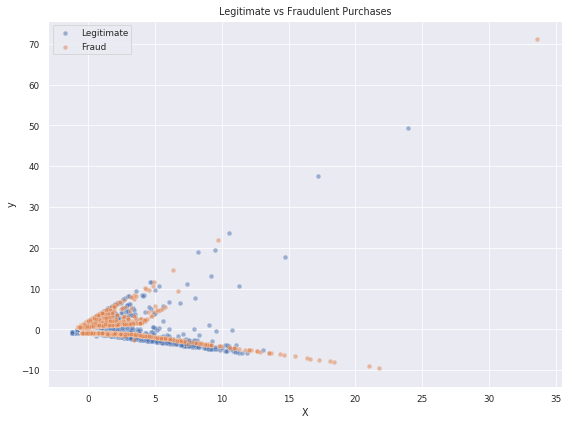

In [87]:
produce_plot(reduce_features(rus_resampled), min_alpha=0.5)

In [19]:
from imblearn.over_sampling import SMOTE

In [20]:
sm = SMOTE(random_state=42)

In [21]:
sm_resampled = resample(df_u, sm)
print(sm_resampled.shape)
print()
print(sm_resampled.isFraud.value_counts())

(12708814, 12)

1    6354407
0    6354407
Name: isFraud, dtype: int64


In [22]:
sm_sample = sm_resampled.sample(n=10000, random_state=42)

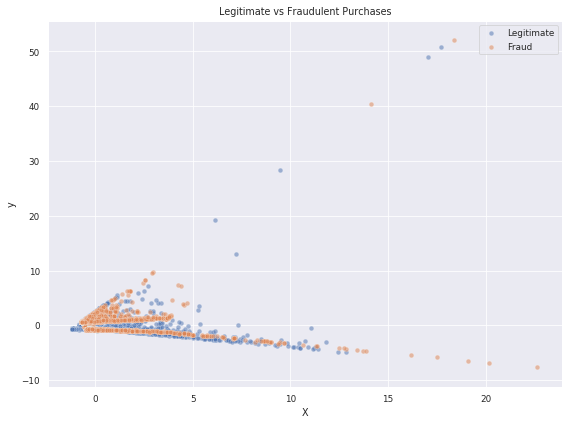

In [23]:
produce_plot(reduce_features(sm_sample), min_alpha=0.5)

Let's go back and resample the data now that we have some more representative data points

In [ ]:
first_col = rus_resampled.pop('isFraud')
rus_resampled.insert(0, 'isFraud', first_col)

In [ ]:
X = rus_resampled.drop('isFraud', 1)
y = rus_resampled.isFraud

In [ ]:
# X.head(n=5)
# X.shape

In [ ]:
# y.head(n=5)
# X.shape

In [ ]:
train_ratio = 0.70
validation_ratio = 0.15
test_ratio = 0.15

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1 - train_ratio, random_state=42, shuffle=True, stratify=y)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio)) 
# X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=test_ratio/(test_ratio + validation_ratio), random_state=42, shuffle=True, stratify=y) 

# print(X_train, X_val, X_test)

In [ ]:
# X_train, X_val, X_test = np.split(rus_resampled.sample(frac=1), [int(0.7 * len(rus_resampled)), int(0.9 * len(rus_resampled))])

Once again we have to apply the scaler

In [ ]:
scaler = MinMaxScaler()
# scaler = RobustScaler()
# scaler = StandardScaler()

scaler.fit(X_train)

In [ ]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_val = scaler.transform(X_val)

In [ ]:
np.savetxt('train.csv', X_train, delimiter=',')
np.savetxt('test.csv', X_test, delimiter=',')
np.savetxt('validation.csv', X_val, delimiter=',')

In [ ]:
boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_train_location = 's3://{}/{}/train'.format(bucket, prefix)
print('Uploaded training data location: {}'.format(s3_train_location))

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'test/test.csv')).upload_file('test.csv')
s3_test_location = 's3://{}/{}/test'.format(bucket, prefix)
print('Uploaded test data location: {}'.format(s3_test_location))

boto3.Session().resource('s3').Bucket(bucket).Object(os.path.join(prefix, 'validation/validation.csv')).upload_file('validation.csv')
s3_validation_location = 's3://{}/{}/validation'.format(bucket, prefix)
print('Uploaded validation data location: {}'.format(s3_validation_location))

s3_output_location = 's3://{}/{}/output'.format(bucket, prefix)
print('Training artifacts will be uploaded to: {}'.format(s3_output_location))

In [ ]:
s3_input_train = sagemaker.inputs.TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'train'), content_type='text/csv')

s3_input_validation = sagemaker.inputs.TrainingInput("s3://{}/{}/{}/".format(bucket, prefix, 'validation'), content_type='text/csv')

We now have all the files uploaded to S3 so it is time to define the XGBoost parameters

In [ ]:
xgboost_container = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, 'latest')

In [ ]:
instance_type='ml.m5.xlarge'

hyperparameters = {
        "alpha":"0.2",
        "max_depth":"10",
        "eta":"0.12",
        "gamma":"2.0",
        "min_child_weight":"8.5",
        "subsample":"0.6",
        "objective":"binary:logistic",
        "num_round":"20",
        "eval_metric":"auc"
        }

In [ ]:
smote_xgb = sagemaker.estimator.Estimator(image_uri=xgboost_container,
                                          hyperparameters=hyperparameters,
                                          role=sagemaker.get_execution_role(), 
                                          instance_count=1, 
                                          instance_type=instance_type,
                                          output_path=s3_output_location,
                                          sagemaker_session=sess)

In [ ]:
%%time
smote_xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

The model is now created so it is time to deploy the endpoint to test

In [ ]:
%%time
smote_predictor = smote_xgb.deploy(initial_instance_count=1,
                                   model_name="xgb-smote-model-01",
                                   endpoint_name="xgb-smote-endpoint-01",
                                   instance_type=instance_type,
                                   serializer=CSVSerializer(),
                                   deserializer=None)

In [ ]:
# use if already deployed

# endpoint_name = "xgb-smote-endpoint-01"
# smote_predictor = sagemaker.predictor.Predictor(endpoint_name=endpoint_name)

In [ ]:
def predict(current_predictor, data, rows=500):
    split_array = np.array_split(data, int(data.shape[0] / float(rows) + 1))
    predictions = ''
    for array in split_array:
        predictions = ','.join([predictions, current_predictor.predict(array).decode('utf-8')])

    return np.fromstring(predictions[1:], sep=',')

In [ ]:
%%time
smote_raw_predictions = predict(smote_predictor, X_test[:, 1:])

In [ ]:
smote_predictions = np.where(smote_raw_predictions > 0.5, 1, 0)

In [ ]:
%%time
y_train_preds = predict(smote_predictor, X_train[:, 1:])

In [ ]:
%%time
y_valid_preds = predict(smote_predictor, X_val[:, 1:])

In [ ]:
def calc_specificity(y_actual, y_pred, thresh):
    # calculates specificity
    return sum((y_pred < thresh) & (y_actual == 0)) /sum(y_actual ==0)

def print_report(y_actual, y_pred, thresh):
    
    auc = roc_auc_score(y_actual, y_pred)
    accuracy = accuracy_score(y_actual, (y_pred > thresh))
    recall = recall_score(y_actual, (y_pred > thresh))
    precision = precision_score(y_actual, (y_pred > thresh))
    specificity = calc_specificity(y_actual, y_pred, thresh)

    print('AUC:%.3f'%auc)
    print('accuracy:%.3f'%accuracy)
    print('recall:%.3f'%recall)
    print('precision:%.3f'%precision)
    print('specificity:%.3f'%specificity)
    print(' ')
    return auc, accuracy, recall, precision, specificity

In [ ]:
thresh = 0.5

print('XGBoost Classifier')
print('Training:')
xgb_train_auc, xgb_train_accuracy, xgb_train_recall, xgb_train_precision, xgb_train_specificity = print_report(y_train, y_train_preds, thresh)

print('Validation:')
xgb_valid_auc, xgb_valid_accuracy, xgb_valid_recall, xgb_valid_precision, xgb_valid_specificity = print_report(y_val, y_valid_preds, thresh)

In [ ]:
def plot_confusion_matrix(y_test, y_pred):

    cm  = confusion_matrix(y_test, y_pred)
    # Get the per-class normalized value for each cell
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # We color each cell according to its normalized value, annotate with exact counts.
    ax = sns.heatmap(cm_norm, annot=cm, fmt="d", cmap="Blues")
    ax.set(xticklabels=["non-fraud", "fraud"], yticklabels=["non-fraud", "fraud"])
    ax.set_ylim([0,2])
    plt.title('Confusion Matrix')
    plt.ylabel('Real Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

print("Balanced accuracy = {}".format(balanced_accuracy_score(y_test, smote_predictions)))
print("Cohen's Kappa = {}".format(cohen_kappa_score(y_test, smote_predictions)))

In [ ]:
plot_confusion_matrix(y_test, smote_predictions)

In [ ]:
from sklearn import metrics

auc = round(roc_auc_score(y_test, y_pred), 4)
print('AUC is ' + repr(auc))

fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)

plt.title('ROC Curve')
plt.plot(fpr, tpr, 'b',
label='AUC = %0.2f'% auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

In [ ]:
smote_predictor.delete_model()
smote_predictor.delete_endpoint()
sm_client = boto3.client('sagemaker', region_name=boto3.Session().region_name)
waiter = sm_client.get_waiter('endpoint_deleted')
waiter.wait(EndpointName="xgb-smote-endpoint-01")